# 7.4. 含并行连结的网络（GoogLeNet）

在2014年的ImageNet图像识别挑战赛中，一个名叫GoogLeNet (Szegedy et al., 2015)的网络架构大放异彩。 GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。 这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。 毕竟，以前流行的网络使用小到1X1，大到11X11的卷积核。 本文的一个观点是，有时使用不同大小的卷积核组合是有利的。 本节将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，现在有了更好的训练方法，这些特性不是必要的。

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 7.4.1. Inception块

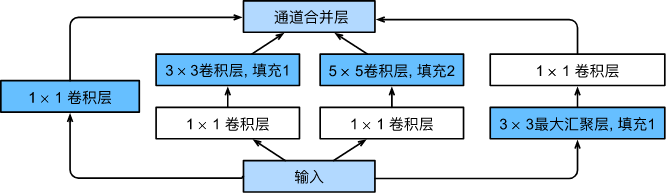
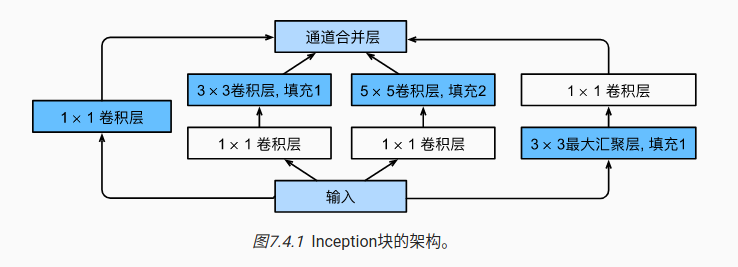

Inception块由四条并行路径组成。 前三条路径使用窗口大小为1X1、3X3和5X5的卷积层，从不同空间大小中提取信息。 中间的两条路径在输入上执行1X1卷积，以减少通道数，从而降低模型的复杂性。 第四条路径使用3X3最大汇聚层，然后使用1X1卷积层来改变通道数。 这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。

In [3]:
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

# 7.4.2. GoogLeNet模型

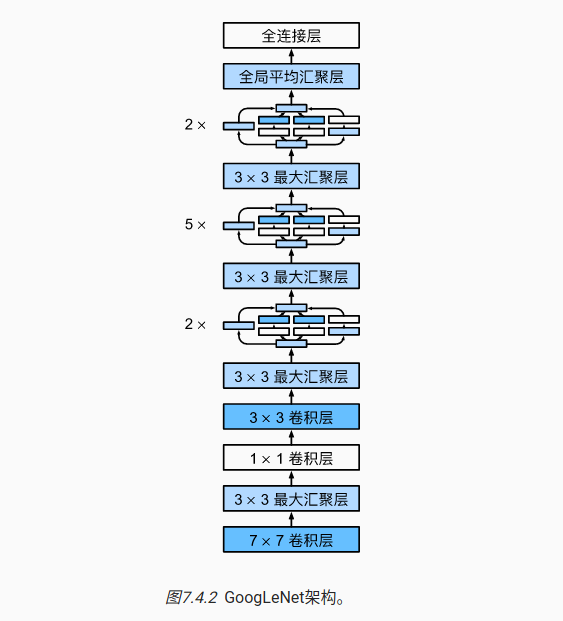

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [5]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [9]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


# 7.4.3. 训练模型

OSError: [Errno 12] Cannot allocate memory

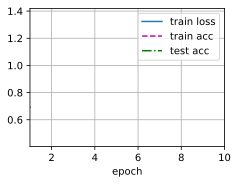

In [12]:
lr, num_epochs, batch_size = 0.1, 10, 8
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.4.4. 小结

Inception块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大汇聚层来并行抽取信息，并使用1X1卷积层减少每像素级别上的通道维数从而降低模型复杂度。

GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在ImageNet数据集上通过大量的实验得来的。

GoogLeNet和它的后继者们一度是ImageNet上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。

# 7.4.5. 练习